In [2]:
import generator
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Activation,LSTM,Bidirectional
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [3]:
files , json = generator.gen()

In [28]:
'''model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
'''
# With custom backward layer
model = Sequential()
forward_layer = LSTM(512, return_sequences=True)
backward_layer = LSTM(512, activation='relu', return_sequences=True,
                   go_backwards=True)
model.add(Bidirectional(forward_layer, backward_layer=backward_layer,
                     input_shape=(40,1)))
model.add(Dense(256))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [36]:
model = Sequential()
model.add(LSTM(512,input_shape=(40,1)))
model.summary()

In [202]:
def calc_euclidian_dists(x, y):
    """
    Calculate euclidian distance between two 3D tensors.
    Args:
        x (tf.Tensor):
        y (tf.Tensor):
    Returns (tf.Tensor): 2-dim tensor with distances.
    """
    n = x.shape[0]
    m = y.shape[0]
    x = tf.tile(tf.expand_dims(x, 1), [1, m, 1])
    y = tf.tile(tf.expand_dims(y, 0), [n, 1, 1])
    return tf.reduce_mean(tf.math.pow(x - y, 2), 2)

def cosine_similarity(matrix, vector):
    ''' Computes cosine similarity of a given vector with vector rows from matrix'''

    # normalize input
    norm_matrix = tf.nn.l2_normalize(matrix, 1)
    norm_vector = tf.nn.l2_normalize(tf.transpose(vector,[1,0]), 0)

    # multiply row i with row j using transpose
    similarity = tf.matmul(norm_matrix, norm_vector)

    return similarity

def const_loss(result):
    mom = 0
    t = 0.07
    losses = tf.convert_to_tensor(np.ndarray((1,1)),dtype=tf.float32)
    for i,dim in enumerate(result):
        if i==0:
            prev_dim = dim
            continue
        #child = tf.math.exp(pl.cosine_similarity(tf.expand_dims(dim,axis=0),tf.expand_dims(prev_dim,axis=0))/t)
        #child = tf.math.exp(calc_euclidian_dists(tf.expand_dims(dim,axis=0),tf.expand_dims(prev_dim,axis=0))/t)
        child = tf.math.exp(cosine_similarity(tf.expand_dims(dim,axis=0),tf.expand_dims(prev_dim,axis=0))/t)
        mom = mom + child
        prev_dim = dim
        loss = -tf.math.log(child/mom)
        losses = tf.concat([losses,loss],axis=1)
    #return tf.reduce_mean(losses)
    return tf.reduce_mean(losses,axis=1)

In [203]:
model.trainable_variables

[<tf.Variable 'lstm_22/kernel:0' shape=(1, 2048) dtype=float32, numpy=
 array([[-0.11171179,  0.06411009, -0.00749997, ...,  0.01915425,
          0.10777192, -0.0145001 ]], dtype=float32)>,
 <tf.Variable 'lstm_22/recurrent_kernel:0' shape=(512, 2048) dtype=float32, numpy=
 array([[ 0.01754163,  0.03197287, -0.02924446, ...,  0.03561358,
          0.07278486,  0.01579057],
        [ 0.07100428,  0.11866315, -0.07574588, ...,  0.03986568,
         -0.21760714,  0.12987232],
        [-0.04425896,  0.11314078,  0.03470216, ..., -0.02406719,
         -0.03993458,  0.07756677],
        ...,
        [-0.06868571,  0.07314322, -0.01161574, ..., -0.09968039,
         -0.02199596, -0.1351476 ],
        [ 0.12436603, -0.0272786 ,  0.0972615 , ..., -0.01253037,
         -0.16298096,  0.02557914],
        [-0.06835441,  0.08708334, -0.18595076, ..., -0.10861194,
         -0.00422815, -0.11826968]], dtype=float32)>,
 <tf.Variable 'lstm_22/bias:0' shape=(2048,) dtype=float32, numpy=
 array([-0.20636

In [211]:
results = []
import sklearn.metrics.pairwise as pl
opt = tf.keras.optimizers.RMSprop(10e-2)

train_loss = tf.keras.metrics.Mean(name='train_loss')

with tf.device(f'GPU:{0}'):
    for k,i in enumerate(files):
        wav,_ = librosa.load(files[i]['file_path'])
        mfcc = tf.cast(tf.expand_dims(librosa.feature.mfcc(wav,n_mfcc = 40).T,axis=2),tf.float32)
        print(mfcc.shape)
        #mfcc = mfcc.reshape(mfcc.shape[1],40)
        with tf.GradientTape() as tape:
            result = model(mfcc)
            loss = const_loss(result)

        gradients = tape.gradient(loss,model.trainable_variables)
        #print(gradients)
        opt.apply_gradients(zip(gradients,model.trainable_variables))
        train_loss(loss)
        if k %20 == 0:
            print(train_loss.result().numpy())

(633, 40, 1)
5.447341
(606, 40, 1)
(339, 40, 1)
(490, 40, 1)
(858, 40, 1)
(506, 40, 1)
(686, 40, 1)
(306, 40, 1)
(761, 40, 1)
(709, 40, 1)
(517, 40, 1)
(707, 40, 1)
(624, 40, 1)
(669, 40, 1)
(603, 40, 1)
(272, 40, 1)
(623, 40, 1)
(364, 40, 1)
(546, 40, 1)
(667, 40, 1)
(647, 40, 1)
5.348174
(403, 40, 1)
(384, 40, 1)
(562, 40, 1)
(482, 40, 1)
(520, 40, 1)
(427, 40, 1)
(368, 40, 1)
(223, 40, 1)
(185, 40, 1)
(156, 40, 1)
(517, 40, 1)
(612, 40, 1)
(402, 40, 1)
(288, 40, 1)
(405, 40, 1)
(274, 40, 1)
(659, 40, 1)
(304, 40, 1)
(184, 40, 1)
(676, 40, 1)
5.1340427
(703, 40, 1)
(409, 40, 1)
(373, 40, 1)
(331, 40, 1)
(296, 40, 1)
(252, 40, 1)
(460, 40, 1)
(392, 40, 1)
(237, 40, 1)
(252, 40, 1)
(250, 40, 1)
(439, 40, 1)
(98, 40, 1)
(637, 40, 1)
(264, 40, 1)
(472, 40, 1)
(100, 40, 1)
(667, 40, 1)
(513, 40, 1)
(444, 40, 1)
5.030077
(250, 40, 1)
(262, 40, 1)
(194, 40, 1)
(367, 40, 1)
(215, 40, 1)
(633, 40, 1)
(263, 40, 1)
(252, 40, 1)
(370, 40, 1)
(413, 40, 1)
(170, 40, 1)
(709, 40, 1)
(381, 40, 1)
(2

KeyboardInterrupt: 

In [214]:
model = Sequential()
model.add(LSTM(128,input_shape=(40,1)))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 128)               66560     
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________


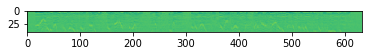

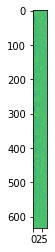

5.447303


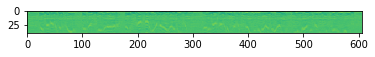

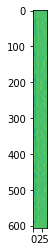

KeyboardInterrupt: 

In [225]:
results = []
import sklearn.metrics.pairwise as pl
opt = tf.keras.optimizers.Adam(10e-2)

train_loss = tf.keras.metrics.Mean(name='train_loss')

with tf.device(f'GPU:{0}'):
    for k,i in enumerate(files):
        wav,_ = librosa.load(files[i]['file_path'])
        mfcc = tf.cast(tf.expand_dims(librosa.feature.mfcc(wav,n_mfcc = 40).T,axis=2),tf.float32)
        plt.imshow(librosa.feature.mfcc(wav,n_mfcc = 40))
        plt.show()
        plt.imshow(np.squeeze(mfcc))
        plt.show()
        #mfcc = mfcc.reshape(mfcc.shape[1],40)
        with tf.GradientTape() as tape:
            result = model(mfcc)
            loss = const_loss(result)

        gradients = tape.gradient(loss,model.trainable_variables)
        #print(gradients)
        opt.apply_gradients(zip(gradients,model.trainable_variables))
        train_loss(loss)
        if k %20 == 0:
            print(train_loss.result().numpy())